In [1]:
import numpy as np

In [2]:
# load data
fname = './data/joystick_track.npz'
alldat = np.load(fname, allow_pickle=True)['dat']

In [3]:
!pip install tensorflow


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [5]:
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(3)

Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


c:\Users\thewa\miniconda3\Lib\site-packages\torch\__init__.py:690: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [6]:
# Define the LSTM Autoencoder Model
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)

    def forward(self, x):
        # Encode
        _, (hidden, cell) = self.encoder(x)
        # Repeat the hidden state for each time step in the sequence
        repeated_hidden = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        # Decode
        decoded, _ = self.decoder(repeated_hidden)
        return decoded

- 2 LSTM models, one for encoding and one for decoding
- The encoder LSTM model is used to encode the input sequence into a fixed-length context vector
- The decoder LSTM model is used to generate the output sequence from the context vector
- In the forward pass, the encoder outputs the hidden and cell states of the LSTM model at the last time step
- The context vector is the concatenation of the hidden and cell states of the encoder
- the hidden is then repeated for each time step of the decoder
- The decoder outputs the hidden and cell states of the LSTM model at each time step

In [7]:

# Prepare the Data
sequence = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
sequence = sequence.reshape((1, len(sequence), 1))  # [samples, timesteps, features]
sequence = torch.tensor(sequence, dtype=torch.float32)


- Why is the sequence reshaped before being passed to the tensor?  
The input sequence is reshaped to have the batch size as the first dimension and the sequence length as the second dimension, as this is what the LSTM model expects as input.

In [8]:

# Hyperparameters
input_dim = 1
hidden_dim = 100
num_layers = 1
num_epochs = 300
learning_rate = 0.001


In [9]:

# Initialize the Model, Loss Function, and Optimizer
model = LSTMAutoencoder(input_dim, hidden_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [10]:

# Train the Model
for epoch in range(num_epochs):
    model.train()
    output = model(sequence)
    loss = criterion(output, sequence)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [50/300], Loss: 0.0532
Epoch [100/300], Loss: 0.0178
Epoch [150/300], Loss: 0.0022
Epoch [200/300], Loss: 0.0018
Epoch [250/300], Loss: 0.0010
Epoch [300/300], Loss: 0.0005


In [11]:

# Evaluate the Model
model.eval()
with torch.no_grad():
    reconstructed = model(sequence)
    print("Original Sequence:", sequence.detach().cpu().numpy().flatten())
    print("Reconstructed Sequence:", reconstructed.detach().cpu().numpy().flatten())
    print("Accuracy:", (1 - criterion(reconstructed, sequence).item()) * 100, "%")


Original Sequence: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Reconstructed Sequence: [0.08706661 0.18373486 0.28859183 0.3985688  0.5088333  0.61338407
 0.70641994 0.7839322  0.84461796]
Accuracy: 99.95346956129652 %


In [12]:
# new hyperparameter
future_steps = 3
output_dim = 1

In [13]:
# Define the Composite LSTM Autoencoder Model
class CompositeLSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(CompositeLSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder_reconstruction = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
        self.decoder_prediction = nn.LSTM(hidden_dim, output_dim, num_layers, batch_first=True)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x, future_steps):
        # Encode
        _, (hidden, cell) = self.encoder(x)
        
        # Repeat the hidden state for each time step in the sequence
        repeated_hidden = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        
        # Decode for reconstruction
        reconstructed, _ = self.decoder_reconstruction(repeated_hidden)
        
        # Repeat the hidden state for future steps
        future_hidden = hidden.repeat(future_steps, 1, 1).permute(1, 0, 2)
        
        # Decode for prediction
        predicted, _ = self.decoder_prediction(future_hidden)
        
        return reconstructed, predicted

This model does prediction as well as reconstruction

In [14]:
# Initialize the Model, Loss Function, and Optimizer
model = CompositeLSTMAutoencoder(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:

# Train the Model
def train_composite_model(model, sequence, future_steps, num_epochs, criterion, optimizer):
    for epoch in range(num_epochs):
        model.train()
        reconstructed, predicted = model(sequence, future_steps)
        loss_reconstruction = criterion(reconstructed, sequence)
        loss_prediction = criterion(predicted, sequence[:, :future_steps, :])
        loss = loss_reconstruction + loss_prediction
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [16]:
train_composite_model(model, sequence, future_steps, num_epochs, criterion, optimizer)

Epoch [50/300], Loss: 0.0232
Epoch [100/300], Loss: 0.0011
Epoch [150/300], Loss: 0.0008
Epoch [200/300], Loss: 0.0008
Epoch [250/300], Loss: 0.0007
Epoch [300/300], Loss: 0.0007


In [17]:

# Evaluate the Model
model.eval()
with torch.no_grad():
    reconstructed, predicted = model(sequence, future_steps)
    print("Original Sequence:", sequence.detach().cpu().numpy().flatten())
    print("Reconstructed Sequence:", reconstructed.detach().cpu().numpy().flatten())
    print("Predicted Future Sequence:", predicted.detach().cpu().numpy().flatten())

Original Sequence: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
Reconstructed Sequence: [0.10002718 0.20514363 0.31315318 0.42100808 0.52500767 0.6212813
 0.7064799  0.77844024 0.83653086]
Predicted Future Sequence: [0.09987517 0.19999722 0.29931393]


# Time for Joystick ECOG Data

the plan is to use the auto encoder to train a decoder across all subjects to produce predictions for the joystick data

In [18]:
# HELPER FUNCTIONS: LOADING/PROCESSING DATA
import math

def Vnormalise(_V):
    Vmax =  max((max(x) for x in _V))
    Vmin = min((min(x) for x in _V))
    _V_norm = (_V - Vmin)/(Vmax - Vmin)
    return _V_norm

def normalise(_V):
    _V_norm = (_V - min(_V))/(max(_V) - min(_V))
    return _V_norm

def Xnormalise(_x, xmin, xmax):
    _x_norm = (_x - xmin)/(xmax - xmin)
    return _x_norm
    
def Xdenormalise(_x, xmin, xmax):
    _x_denorm = _x*(xmax - xmin) + xmin
    return _x_denorm

def Ynormalise(_y, ymin, ymax):
    _y_norm = (_y - ymin)/(ymax - ymin)
    return _y_norm
    
def Ydenormalise(_y, ymin, ymax):
    _y_denorm = _y*(ymax - ymin) + ymin
    return _y_denorm

  
def downsample(signal, factor):
  nbins = math.floor(nt/factor)
  signal_norm = np.zeros((nbins, 1))
  for ibin in range(nbins):
    binstart = ibin * factor
    binend = binstart + factor
    signal_norm[ibin, 0] = np.mean(signal[binstart:binend])

  return signal_norm



In [19]:
dat = alldat[0]

# i need to pass the data for each subject to the encoder, which then 
for d in dat:
    _V = d['V']
    _V_norm = Vnormalise(_V)
    _V_norm = _V_norm.reshape(-1, 1)
    nt = _V_norm.shape[0]
    


# Wait, this model is wrong

I need a model that can take all the ecog data, produce low dimensional representation, and then use that to predict the X, Y magnitude vectors of the target on the screen as produced by some transformation of the cursorX and cursorY values. This 


In [20]:
import torch
print('Is cuda?', torch.cuda.is_available())
if torch.cuda.is_available():
    !nvcc --version
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is cuda? True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:30:10_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


In [21]:
import numpy as np

def normalize_joystick_readings(x, y):
    # adjust the range of the readings to be between 0 and 1
    x_magnitude = normalise(x)
    y_magnitude = normalise(y)
    return x_magnitude, y_magnitude


# choose patient
patient_idx = 0

d = dat[patient_idx]
targetX = d['targetX']
targetY = d['targetY']
# Normalize the readings
x_magnitude, y_magnitude = normalize_joystick_readings(targetX, targetY)

magnitudes = np.concatenate((x_magnitude, y_magnitude), axis=1)
print(magnitudes.shape)


(372760, 2)


In [22]:
from torch.utils.data import Dataset, DataLoader

class JoystickDataset(Dataset):
    def __init__(self, ecog_data, magnitudes):
        self.ecog_data = ecog_data
        self.magnitudes = magnitudes

    def __len__(self):
        return len(self.ecog_data)

    def __getitem__(self, idx):
        x = self.ecog_data[idx]
        y = self.magnitudes[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Example: Load your ECOG data here
ecog_data =  d['V']

# Create dataset and dataloader
# ecog is x, magnitudes is y
dataset = JoystickDataset(ecog_data, magnitudes)
generator = torch.Generator(device=device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, generator=generator)
print(ecog_data.shape)


(372760, 60)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.lstm = nn.LSTM(64 * 15 * 15, 128, batch_first=True)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: [batch_size, 1, channels, time_points]
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1, 64 * x.size(2) * x.size(3))  # Reshape for LSTM: [batch_size, sequence_length, features]
        x, _ = self.lstm(x)
        return x[:, -1, :]  # Take the output of the last time step





In [24]:
class CoordPredictor(nn.Module):
    def __init__(self):
        super(CoordPredictor, self).__init__()
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Output x and y coordinates

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [25]:

class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.coord_predictor = CoordPredictor()
        
    def forward(self, x):
        features = self.feature_extractor(x)
        coords = self.coord_predictor(features)
        return coords


In [26]:
# Assuming you have your data loaders ready
model = CombinedModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for i, (ecog_data, target_coords) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(ecog_data)
        loss = criterion(outputs, target_coords)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: Given input size: (32x1x60). Calculated output size: (32x0x30). Output size is too small

In [ ]:
# pass dataset through encoder


c:\Users\thewa\miniconda3\Lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


RuntimeError: shape '[24000, 1]' is invalid for input of size 400

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

class FeatureExtractor(nn.Module):
    def __init__(self, input_channels, sequence_length):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        
        # Calculate the output size after convolution and pooling
        conv_output_length = sequence_length // 4  # Two pooling layers with kernel size 2
        self.fc1 = nn.Linear(64 * conv_output_length, 128)
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PredictionModel(nn.Module):
    def __init__(self, feature_dim):
        super(PredictionModel, self).__init__()
        self.fc1 = nn.Linear(feature_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ECoGModel(nn.Module):
    def __init__(self, input_channels, sequence_length):
        super(ECoGModel, self).__init__()
        self.feature_extractor = FeatureExtractor(input_channels, sequence_length)
        self.prediction_model = PredictionModel(64)

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.prediction_model(features)
        return predictions

# Hyperparameters
input_channels = 60
sequence_length = 372760  # Adjust based on your data
learning_rate = 0.001
num_epochs = 50

# Model, loss function, and optimizer
model = ECoGModel(input_channels, sequence_length)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Dummy Data for illustration purposes
# Replace with actual ECoG data and target coordinates
ecog_data = torch.randn(1, input_channels, sequence_length)  # (batch_size, channels, sequence_length)
target_coords = torch.randn(sequence_length, 2)  # (sequence_length, 2)
# real data: (sequence_length, in_channels) as ( (372760, 60) for ecog, coordinate magnitudes as (372760, 2)
# add batch dimension to ecog_data numpy array
dataset = JoystickDataset(ecog_data, target_coords)
generator = torch.Generator(device=device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, generator=generator)
# Training Loop with dataloader
for epoch in range(num_epochs):
    for i, (ecog_data, target_coords) in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()
        print(ecog_data.shape)
        outputs = model(ecog_data)
        loss = criterion(outputs, target_coords)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete.")


C:\Users\thewa\AppData\Local\Temp\ipykernel_15492\1184376144.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
Epoch [10/50], Loss: 150.2608
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
Epoch [20/50], Loss: 1.3982
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
Epoch [30/50], Loss: 0.7412
torch.Size([1, 60, 372760])
torch.Size([1, 60, 372760])
torch.Size([1, 60,

KeyboardInterrupt: 

IndexError: too many indices for tensor of dimension 1

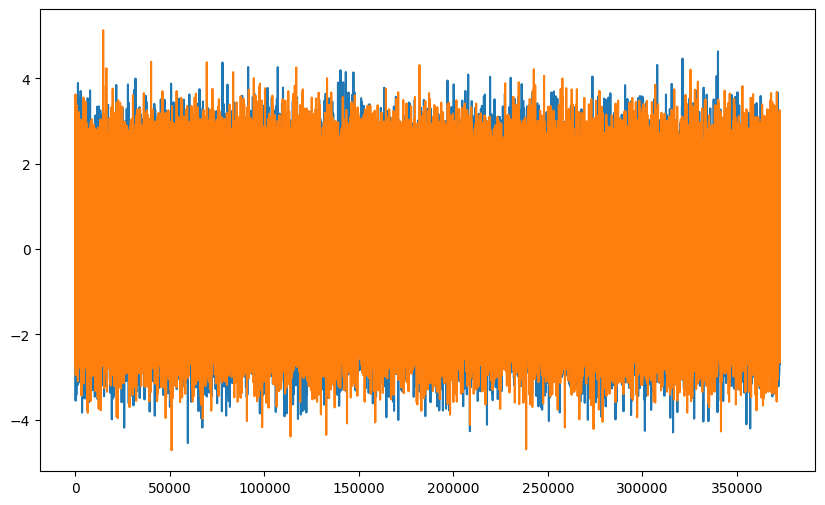

In [ ]:
# plot
import matplotlib.pyplot as plt

# check if data is in cuda tensor
if torch.cuda.is_available():
    ecog_data = ecog_data.cpu()
    target_coords = target_coords.cpu()
    outputs = outputs.cpu()

plt.figure(figsize=(10, 6))
plt.plot(target_coords[:, 0], label='Target X Coordinate')
plt.plot(target_coords[:, 1], label='Target Y Coordinate')
plt.plot(outputs.squeeze(0).detach()[:, 0], label='Predicted X Coordinate')
plt.plot(outputs.squeeze(0).detach()[:, 1], label='Predicted Y Coordinate')
plt.xlabel('Time Step')
plt.ylabel('Coordinate Value')
plt.title('ECoG Data Prediction')
plt.legend()
plt.show()